# Schedule-Adjusted League Table

## Actual League Table

Idea from : [StastBomb Blog Post](https://statsbomb.com/2018/11/introducing-the-schedule-adjusted-league-table/)

In [1]:
import pandas as pd
import numpy as np

In [2]:
fixtures = pd.read_csv(
    '../data/fpl_official/vaastav/data/2021-22/fixtures.csv')

results = (
    fixtures[fixtures['finished'] == True]
    [['team_a', 'team_a_score', 'team_h', 'team_h_score']])

In [3]:
league_table = pd.read_csv(
    '../data/fpl_official/vaastav/data/2021-22/teams.csv'
    )[['id', 'name', 'short_name']]
league_table['points'] = 0

In [4]:
def score_to_points_at_home(row):
    if row['team_a_score'] == row['team_h_score']:
        return 1
    elif row['team_a_score'] < row['team_h_score']:
        return 3
    else:
        return 0

home_results = results.copy()
home_results['points'] = home_results.apply(
    lambda row: score_to_points_at_home(row), axis=1)
home_results = (home_results.loc[:, ['team_a', 'team_h', 'points']])

In [5]:
def score_to_points_at_away(row):
    if row['team_a_score'] == row['team_h_score']:
        return 1
    elif row['team_a_score'] > row['team_h_score']:
        return 3
    else:
        return 0

away_results = results.copy()
away_results['points'] = away_results.apply(
    lambda row: score_to_points_at_away(row), axis=1)
away_results = (away_results.loc[:, ['team_a', 'team_h', 'points']])

In [6]:
def aggregate_points(team):
    return home_results[home_results['team_h'] == team]['points'].sum() +\
           away_results[away_results['team_a'] == team]['points'].sum()

In [7]:
lt = (league_table.id.map(aggregate_points))
league_table['points'] = lt
league_table.sort_values(by=['points'], ascending=False)

,id,name,short_name,points
5,6,Chelsea,CHE,25
10,11,Liverpool,LIV,22
18,19,West Ham,WHU,20
11,12,Man City,MCI,20
12,13,Man Utd,MUN,17
0,1,Arsenal,ARS,17
3,4,Brighton,BHA,16
19,20,Wolves,WOL,16
16,17,Spurs,TOT,15
7,8,Everton,EVE,14


## SALT

In [8]:
from itertools import combinations

In [9]:
def home_points(row):
    if row['team_a_score'] == row['team_h_score']:
        return 1
    elif row['team_a_score'] < row['team_h_score']:
        return 3
    else:
        return 0

home_results = results.copy()
home_results['points'] = home_results.apply(
    lambda row: home_points(row), axis=1)
home_results = (home_results
               .assign(venue = 'home')
               .rename(columns = {
                   'team_h': 'team',
                   'team_a': 'opponent'
               })
               .loc[:, ['team', 'opponent', 'venue', 'points']])

In [10]:
def away_points(row):
    if row['team_a_score'] == row['team_h_score']:
        return 1
    elif row['team_a_score'] > row['team_h_score']:
        return 3
    else:
        return 0

away_results = results.copy()
away_results['points'] = away_results.apply(
    lambda row: away_points(row), axis=1)
away_results = (away_results
               .assign(venue = 'away')
               .rename(columns = {
                   'team_a': 'team',
                   'team_h': 'opponent'
               })
               .loc[:, ['team', 'opponent', 'venue', 'points']])

In [11]:
all_results = pd.concat(
    [home_results, away_results], ignore_index=True)
all_results.head()

,team,opponent,venue,points
0,3,1,home,3
1,13,10,home,3
2,5,4,home,0
3,6,7,home,3
4,8,16,home,3


In [12]:
w = pd.DataFrame(
    index=list(combinations(league_table["id"], 2)),
    columns=league_table["id"]).fillna(0)

for idx, row in w.iterrows():
    w.loc[[idx], idx[0]] = 1
    w.loc[[idx], idx[1]] = -1

W = w.values

In [13]:
def points_per_game_difference(teams):
    same_fixture = (
        all_results[all_results.team == teams[0]]
        .merge(all_results[all_results.team == teams[1]],
            how='inner',
            on=['opponent','venue']))

    if not same_fixture.empty:
        ppg_difference = (
            (same_fixture.points_x.sum() -
            same_fixture.points_y.sum())
            / same_fixture.shape[0]
            )
    else:
        ppg_difference = 0
    
    return ppg_difference

In [14]:
r = w.index.map(points_per_game_difference).values.reshape(w.shape[0], 1)

In [15]:
# Solve Wx = r using Least Squared Error
x = np.linalg.lstsq(W, r, rcond=None)[0]

In [16]:
sorted(zip(league_table['name'], x), key=lambda x: x[1], reverse=True)

[('Chelsea', array([1.13416667])),
 ('Liverpool', array([0.77083333])),
 ('Man City', array([0.7325])),
 ('West Ham', array([0.55833333])),
 ('Man Utd', array([0.43333333])),
 ('Spurs', array([0.27916667])),
 ('Arsenal', array([0.25])),
 ('Leicester', array([0.135])),
 ('Crystal Palace', array([0.10416667])),
 ('Wolves', array([0.06666667])),
 ('Brentford', array([0.02916667])),
 ('Brighton', array([-0.03916667])),
 ('Aston Villa', array([-0.2625])),
 ('Southampton', array([-0.29166667])),
 ('Watford', array([-0.35833333])),
 ('Everton', array([-0.42833333])),
 ('Burnley', array([-0.575])),
 ('Leeds', array([-0.57916667])),
 ('Newcastle', array([-0.91333333])),
 ('Norwich', array([-1.04583333]))]

In [17]:
mapping_table = pd.DataFrame(
     index=list(combinations(league_table["name"], 2)),
     columns=league_table["name"]).fillna(0)

m = (all_results
     .groupby('team')
     .points
     .count()
     .values
     .reshape(len(mapping_table.columns), 1))

In [18]:
adjusted_points = m * (x + all_results.points.mean())

In [19]:
league_table['adj_points'] = adjusted_points
league_table.sort_values(
    by=['points'], ascending=False).drop(["id"], axis=1)

,name,short_name,points,adj_points
5,Chelsea,CHE,25,25.041667
10,Liverpool,LIV,22,21.408333
18,West Ham,WHU,20,19.283333
11,Man City,MCI,20,21.025000
12,Man Utd,MUN,17,18.033333
0,Arsenal,ARS,17,16.200000
3,Brighton,BHA,16,13.308333
19,Wolves,WOL,16,14.366667
16,Spurs,TOT,15,16.491667
7,Everton,EVE,14,9.416667


In [20]:
colors = {
    # https://teamcolorcodes.com/soccer/premier-league-color-codes/
    'ARS': '#EF0107',
    'AVL': '#95bfe5',
    'BHA': '#0057B8',
    'BRE': '#DA291C',
    'BUR': '#6C1D45',
    'CHE': '#034694',
    'CRY': '#1B458F',
    'EVE': '#003399',
    'LEI': '#003090',
    'LEE': '#FFCD00',
    'LIV': '#c8102E',
    'MCI': '#6CABDD',
    'MUN': '#DA291C',
    'NOR': '#FFF200',
    'NEW': '#241F20',
    'SOU': '#d71920',
    'TOT': '#132257',
    'WAT': '#FBEE23',
    'WHU': '#7A263A',
    'WOL': '#FDB913'
}

In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from highlight_text import fig_text

body_font = "Open Sans"
watermark_font = "DejaVu Sans"
text_color = "w"
background = "#282B2F"
title_font = "DejaVu Sans"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['text.color'] = text_color
mpl.rcParams['axes.edgecolor'] = text_color
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6

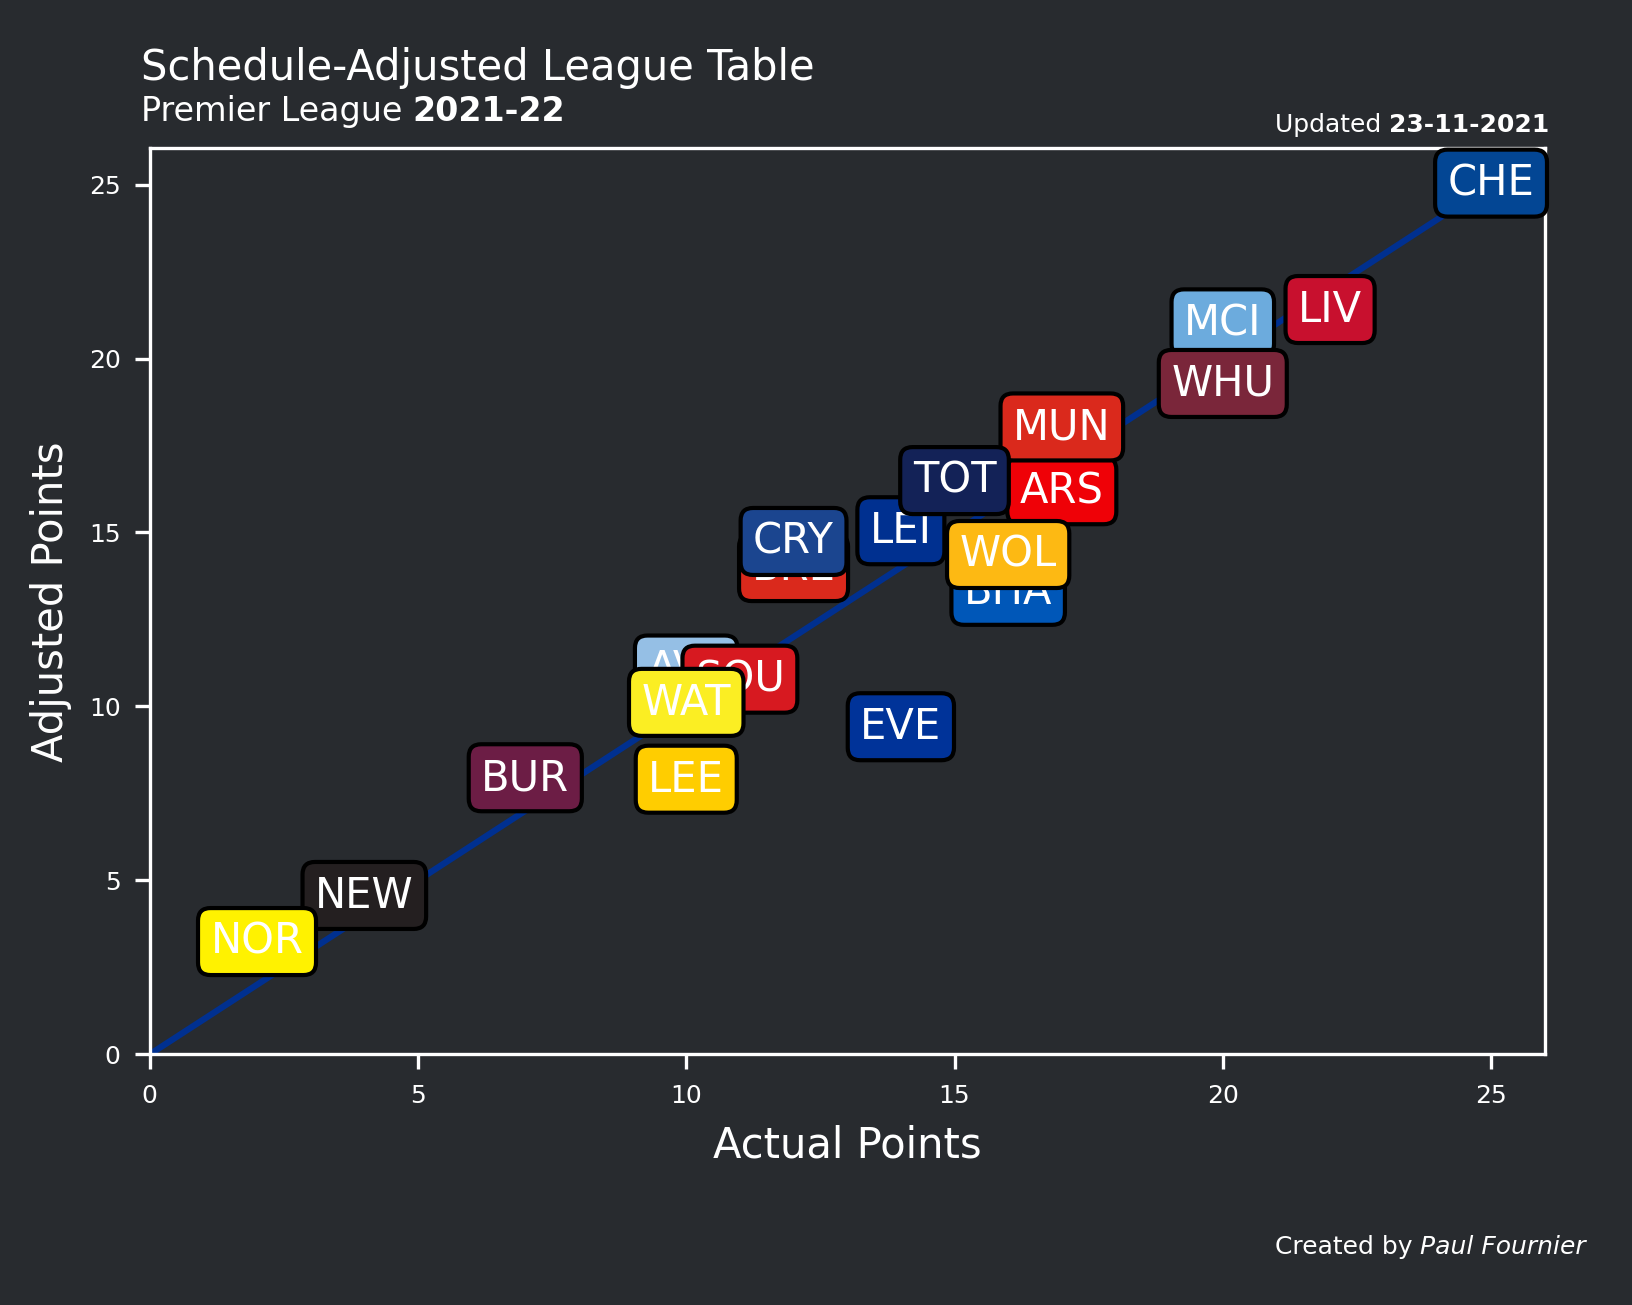

In [22]:
fig, ax = plt.subplots()
fig.set_facecolor(background)
ax.patch.set_alpha(0)

max_1 = league_table["adj_points"].max()
max_2 = league_table["points"].max()
ax.set(xlim=(0, max_2+1), ylim=(0, max_1+1))

ax.set_xlabel('Actual Points')
ax.set_ylabel('Adjusted Points')
ax.xaxis.label.set_color(text_color)
ax.yaxis.label.set_color(text_color)

ref_line = [0.0, max(max_1, max_2)+1]
ax.plot(ref_line, ref_line, color='#003090')

for idx, row in league_table.iterrows():
    ax.annotate(row.values[2],
                xy=(row["points"], row["adj_points"]),
                xycoords='data',
                bbox=dict(boxstyle='round', fc=(colors[row.values[2]])),
                ha='center',
                va='center',
                color='white')

fig_text(
    x=0.12, y=0.965,
    s="Schedule-Adjusted League Table",
    fontsize=10, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.12, y=0.925,
    s="Premier League <2021-22>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=8, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.75, y=0.91,
    s="Updated <23-11-2021>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=6, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.75, y=-0.025,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=6, fontfamily=watermark_font,
    color=text_color)

plt.show()